In [10]:
import random
from libs.node import Node
from libs.node import Station
from libs.node import StationDcf
from libs.node import StationRl
from libs.channel import Channel
from tqdm import tqdm
from config import Config
from libs.allocateModel import Allocator
import matplotlib.pyplot as plt

## Cofigure the simulation parameter

In [11]:
cfg = Config()
global_time = 0
channel = Channel(global_time, [])

station_num = 5
data_rate = 6  # Mbps
# All the lengeth is a mutible of slot

# incule header
pkt_len = 1560
# us
slot_len = 10
sifs = 2
ack_len = 2 + sifs
difs = 4
timeout = ack_len

frame_len = pkt_len * 8 / slot_len / data_rate
stations_list = []
current_througput = []
total_time = 0


## Initialize the stations

In [12]:
for i in range(station_num):
    if cfg.stationType == "Dcf":
        station = StationDcf(i, frame_len, channel,
                             global_time, i, timeout, ack_len, difs, sifs)
    elif cfg.stationType == "RL":
        station = StationRl(i, frame_len, channel,
                            global_time, i, timeout, ack_len, (i+1))
    stations_list.append(station)
    current_througput.append([0])
allocator = Allocator(stations_list, cfg)

==> loading model...
==> loading model...
==> loading model...
==> loading model...
==> loading model...


## Simulate

In [13]:
if cfg.stationType == "Dcf":
    startEpoch = 0
elif cfg.stationType == "RL":
    startEpoch = stations_list[0].epoch

print("==> startEpoch: ", startEpoch)
for i in tqdm(range(startEpoch, startEpoch+cfg.NUM_EPOCHS)):
    for station in stations_list:
        station.simulate(global_time)
        k = station.u_id
        if channel.time > global_time:
            current_througput[k].append(station.total_pkt_time* data_rate * 1500 / 1560/(channel.time+1))
        else:
            current_througput[k].append(station.total_pkt_time* data_rate * 1500 / 1560/(global_time+1))
    global_time = global_time + 1
    channel.update_state(global_time)

    if cfg.shuffleStationList:
        random.shuffle(stations_list)
        
    if i % cfg.allocate_iter == 0 and i > startEpoch+cfg.startAllocationEpoch:
        # print("==> allocate model")
        allocator.allocateModel()

for station in stations_list:
    total_time += station.total_pkt_time
    if cfg.saveModel and cfg.stationType == "RL":
        station.saveModel()
if cfg.saveModel:
    allocator.saveBestModel()
    
print("==> total_time:", total_time)
total_time_channel = 0


  0%|                                                                                | 8/10000 [00:00<02:13, 74.97it/s]

==> startEpoch:  80000



  2%|█▏                                                                            | 150/10000 [00:10<12:33, 13.06it/s]


  2%|█▏                                                                            | 152/10000 [00:10<12:30, 13.13it/s]

last bestStation:-1, now bestStation:[2]
max_total_pkt_time:  208.0



  2%|█▌                                                                            | 202/10000 [00:14<12:18, 13.26it/s]

best station not change



  3%|█▉                                                                            | 252/10000 [00:19<20:40,  7.86it/s]

best station not change



  3%|██▎                                                                           | 302/10000 [00:25<21:16,  7.60it/s]

best station not change



  4%|██▋                                                                           | 352/10000 [00:31<12:42, 12.65it/s]

best station not change



  4%|███▏                                                                          | 402/10000 [00:35<11:58, 13.35it/s]

best station not change



  5%|███▌                                                                          | 452/10000 [00:38<12:38, 12.59it/s]

best station not change



  5%|███▉                                                                          | 502/10000 [00:42<12:02, 13.15it/s]

best station not change



  5%|███▉                                                                          | 506/10000 [00:43<12:06, 13.07it/s]

KeyboardInterrupt: 

## Generate the throughput

In [5]:
for i in range(len(channel.start)):
    # if(i > 0):
    #     if ((channel.start[i] - channel.end[i-1]) < 4):
    #         continue
    if(i > 0):
        if ((channel.start[i] - channel.start[i-1]) < frame_len):
            continue
    total_time_channel += frame_len

print("==> total_time_channel:", total_time_channel)
print("==> channel time:", channel.time)

try:
    throughput = total_time/channel.time * data_rate * 1500 / 1560
    print("==> throughput:", throughput)
except:
    print("can't calculate throughput: division by zero")

for station in stations_list:
    print("station.Id:{}, station.total_pkt_time:{}".format(
        station.Id, station.total_pkt_time))


NameError: name 'total_time_channel' is not defined

In [6]:
current_througput[1]

[0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 5.194805194805195,
 5.194805194805195,
 5.194805194805195,
 5.194805194805195,
 5.194805194805195,
 5.194805194805195,
 5.194805194805195,
 5.194805194805195,
 5.194805194805195,
 5.194805194805195,
 5.194805194805195,
 5.194805194805195,
 5.194805194805195,
 5.194805194805195,
 5.194805194805195,
 5.194805194805195,
 5.194805194805195,
 5.194805194805195,
 5.194805194805195,
 5.194805194805195,
 5.194805194805195,
 5.194805194805195,
 5.194805194805195,
 5.194805194805195,
 5.194805194805195,
 5.194805194805195,
 5.194805194805195,
 5.194805194805195,
 5.194805194805195,
 5.194805194805195,
 5.194805194805195,
 5.194805194805195,
 5.194805194805195,
 5.194805194805195,
 5.194805194805195,
 5.194805194805195,
 5.194805194805195,
 5.194805194805195,
 5.194805194805195,
 5.194805194805195,
 5.194805194805195,
 5.194805194805195,
 5.194805194805195,
 5.1

In [7]:
x = []
for i in range(len(current_througput[1])):
    x.append(i)

In [8]:
x

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


ValueError: x and y must have same first dimension, but have shapes (1990,) and (1989,)

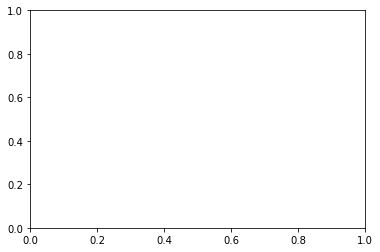

 20%|███████████████▎                                                             | 1988/10000 [02:50<10:17, 12.97it/s]

In [9]:
plt.plot(x, current_througput[0],label='User1')
plt.plot(x, current_througput[1],label='User2')
plt.plot(x, current_througput[2],label='User3')
plt.plot(x, current_througput[3],label='User4')
plt.plot(x, current_througput[4],label='User5')
plt.xlabel('Simulation Time')
plt.ylabel('Throughput Mbps')
plt.legend()
plt.savefig('tpt_all.eps',dpi=1000,format='eps')
#plt.scatter(x, y, color='r')